In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
# modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

colnames = ['surgery', 'age', 'hospital number', 'rectal temperature', 'pulse', 'respiratory rate', 'temperature of extremities', 'peripheral pulse', 'mucous membranes', 'capillary refill time', 'pain', 'peristalsis', 'abdominal distension', 'nasogastric tube',
            'nasogastric reflux', 'nasogastric reflux PH', 'rectal examination', 'abdomen', 'packed cell volume', 'total protein', 'abdominocentesis appearance', 'abdomcentesis total protein', 'outcome', 'surgical lesion', 'lesion type', 'lesion type2', 'lesion type3', 'pathology data']
dropped_colnames = ['nasogastric reflux PH', 'abdominocentesis appearance', 'abdomcentesis total protein',
                    'abdomen', 'nasogastric tube', 'nasogastric reflux', 'rectal examination', 'lesion type2', 'lesion type3']
train_colnames = set(colnames).difference(dropped_colnames)
train_colnames = [x for x in train_colnames if x != "outcome"]
cat_colnames = ['surgery', 'age', 'temperature of extremities', 'peripheral pulse', 'mucous membranes', 'capillary refill time', 'pain', 'peristalsis', 'abdominal distension',
                'surgical lesion', 'pathology data']
numerical_colnames = ['rectal temperature', 'pulse', 'respiratory rate',
                      'packed cell volume', 'total protein']

# Read dataset file
def read_data(dataset_name):
    loc = "data\%s" % (dataset_name)
    df = pd.read_csv(loc, sep=" ", names=colnames, header=None)
    df.columns.names = ["id"]
    df.drop(dropped_colnames, axis=1, inplace=True)
    df = df.replace("?", np.nan)
    df = df.dropna(subset=["outcome"])
    # split into data and target
    X, y = df.loc[:, df.columns != "outcome"], df.loc[:, "outcome"]
    return X, y


X, y = read_data("horse-colic.data")

# Cast Object types to float
for col in train_colnames:
    X = X.astype({col: float})

In [2]:
# convert to numpy arrays
X_numpy = np.array(X)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

# convert integers to one hot encoded variables
hot_y = np_utils.to_categorical(encoded_y)

In [3]:
# Pre-processing
filled_df = X.copy()
# Replacing missing values of categorical attributes with the most frequant value
cat_fill = filled_df.loc[:, cat_colnames]
for col in cat_colnames:
    filled_df[cat_colnames] = cat_fill.fillna(filled_df[col].mode()[0])

# Replacing missing values of numerical attributes with the mean value
filled_df[numerical_colnames] = filled_df[numerical_colnames].fillna(
    filled_df[numerical_colnames].mean()
)

for feature in train_colnames:
  le = LabelEncoder()
  filled_df[feature] = le.fit_transform(filled_df[feature])

# Normalization
normalized_df = filled_df.copy()
to_norm = normalized_df.loc[:, numerical_colnames]
normalized_df[numerical_colnames] = preprocessing.normalize(to_norm)

X = normalized_df


In [4]:
# convert to numpy arrays
X_numpy = np.array(X)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

# convert integers to one hot encoded variables
hot_y = np_utils.to_categorical(encoded_y)

In [19]:
# Separate the test data
x, x_test, y, y_test = train_test_split(X_numpy, hot_y, test_size=0.15, shuffle=True)

# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle=True)

In [20]:
# build a model
model = Sequential()
model.add(Dense(256, input_shape=(X_numpy.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               4864      
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 3)                

In [21]:
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=100, 
                                   restore_best_weights=True)

callbacks = [es]
# now we just update our model fit call
history = model.fit(x_train,
                    y_train,
                    callbacks=callbacks,
                    epochs=1000,
                    batch_size=100,
                    shuffle=True,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/1000
3/3 [==============================] - 0s 56ms/step - loss: 7.2649 - accuracy: 0.4093 - val_loss: 5.3435 - val_accuracy: 0.5641
Epoch 2/1000
3/3 [==============================] - 0s 8ms/step - loss: 6.9100 - accuracy: 0.5767 - val_loss: 3.5603 - val_accuracy: 0.5385
Epoch 3/1000
3/3 [==============================] - 0s 17ms/step - loss: 4.3248 - accuracy: 0.5070 - val_loss: 2.6232 - val_accuracy: 0.1795
Epoch 4/1000
3/3 [==============================] - 0s 11ms/step - loss: 4.7167 - accuracy: 0.3349 - val_loss: 2.3988 - val_accuracy: 0.4103
Epoch 5/1000
3/3 [==============================] - 0s 12ms/step - loss: 4.1215 - accuracy: 0.4140 - val_loss: 2.1252 - val_accuracy: 0.6667
Epoch 6/1000
3/3 [==============================] - 0s 13ms/step - loss: 3.0644 - accuracy: 0.5116 - val_loss: 1.5774 - val_accuracy: 0.5128
Epoch 7/1000
3/3 [==============================] - 0s 11ms/step - loss: 2.5900 - accuracy: 0.4744 - val_loss: 1.2683 - val_accuracy: 0.4615
Epoch 8/1000
3

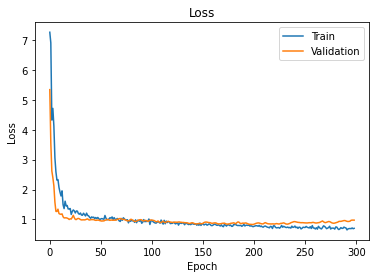

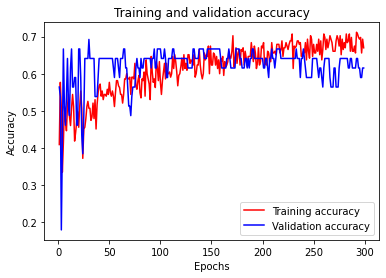

In [22]:
history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot Learning curves (Loss)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# plot Learning curves (Accuracy)
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

[0.56737924 0.23315467 0.19946614]
1.0


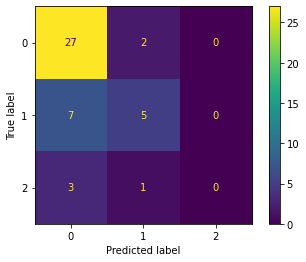

              precision    recall  f1-score   support

           0       0.73      0.93      0.82        29
           1       0.62      0.42      0.50        12
           2       0.00      0.00      0.00         4

    accuracy                           0.71        45
   macro avg       0.45      0.45      0.44        45
weighted avg       0.64      0.71      0.66        45



C:\Users\savag\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\savag\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\savag\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [23]:
preds = model.predict(x_test)
print(preds[0]) # spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1

cm = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1)))